---
CSC 268 Lab 15:  Image Registration
---

This lab will explore the steps involved in image registration.  Our goal will be to produce a smooth panorama from a series of still images.

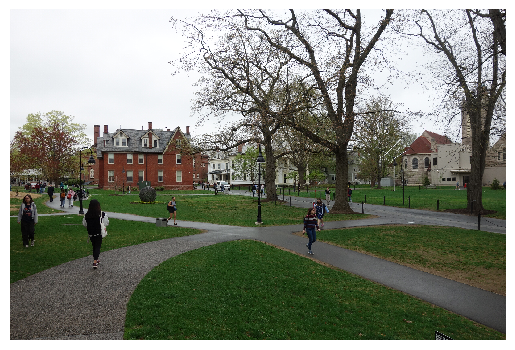

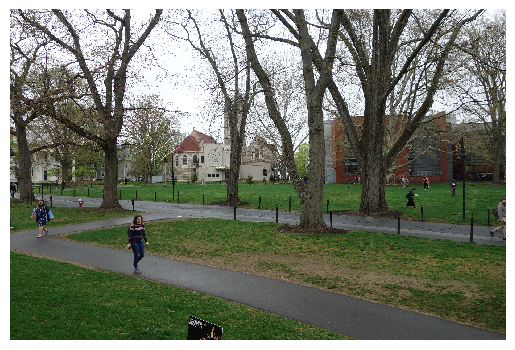

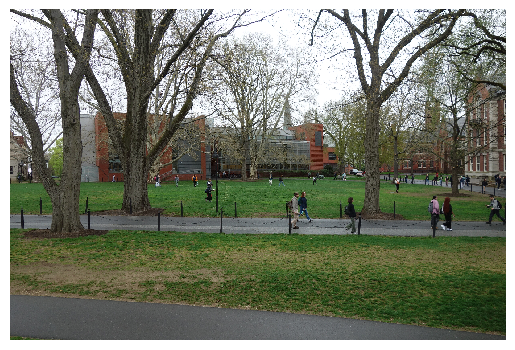

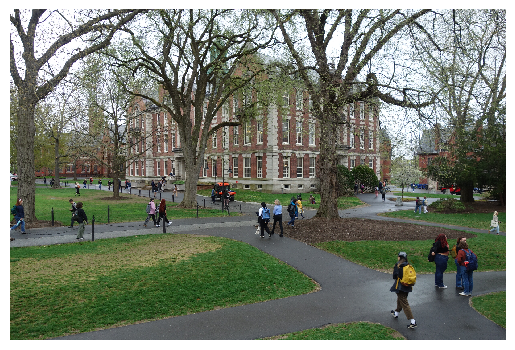

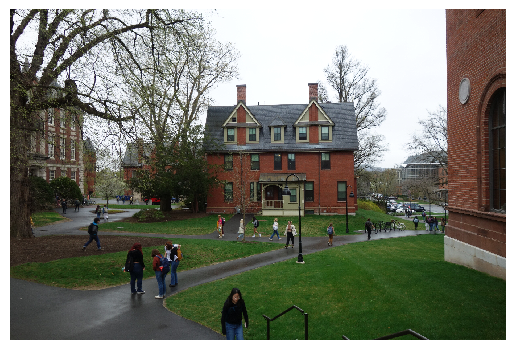

(912, 1368, 3)


In [1]:
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import RegularGridInterpolator, RectBivariateSpline

mpl.rc('image', cmap='gray')

def imshow(img,cmap=None):
    plt.imshow(img,cmap=cmap,interpolation='none')
    plt.axis('off')
    plt.show()
    
lawn1 = cv.imread('lawn1.jpg',cv.IMREAD_COLOR)[::4,::4,[2,1,0]].astype(np.float32)/255.0
lawn2 = cv.imread('lawn2.jpg',cv.IMREAD_COLOR)[::4,::4,[2,1,0]].astype(np.float32)/255.0
lawn3 = cv.imread('lawn3.jpg',cv.IMREAD_COLOR)[::4,::4,[2,1,0]].astype(np.float32)/255.0
lawn4 = cv.imread('lawn4.jpg',cv.IMREAD_COLOR)[::4,::4,[2,1,0]].astype(np.float32)/255.0
lawn5 = cv.imread('lawn5.jpg',cv.IMREAD_COLOR)[::4,::4,[2,1,0]].astype(np.float32)/255.0
imshow(lawn1)
imshow(lawn2)
imshow(lawn3)
imshow(lawn4)
imshow(lawn5)
print(lawn1.shape)

If we leave the images as they are, then the transformations between them will be a complicated projective transformation.  This can be solved in theory, but numerically it introduces a lot more room for error.  We can instead project the images onto cylindrical coordinates (theta,h).  In this coordinate space, different images are related by a simple transformation.  With only two parameters to estimate (the offset in x and the offset in y), our registration should be more robust.  What is more, in a wide panorama involving several images the ends will not be distorted in the same way as if we had projected it onto the plane of a single image.

0.6666666666666666
-1.0 1.0 -0.6666666666666666 0.6666666666666666
-0.8820039053213513 0.8820039053213513
-0.5547001962252291 0.5547001962252291
0.6666666666666666
-0.4359311128636527 0.4359311128636527 -0.9311629430468151 0.9311629430468151


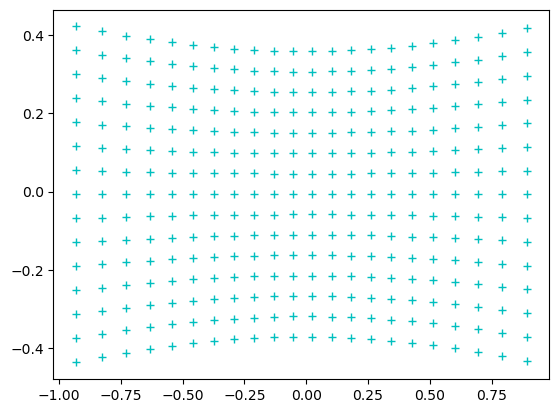

-0.9311629430468151 0.9311629430468151 -0.4359311128636527 0.4359311128636527


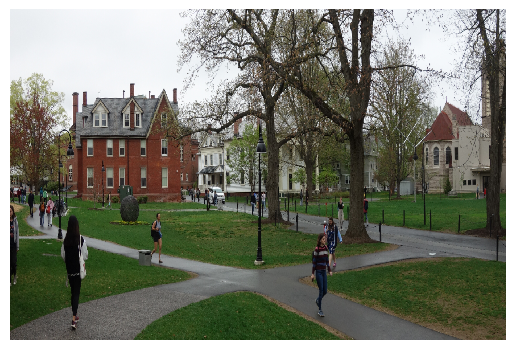

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


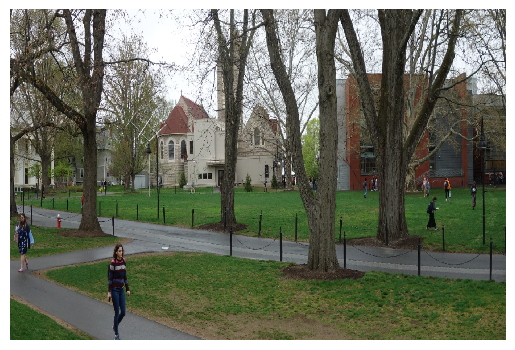

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


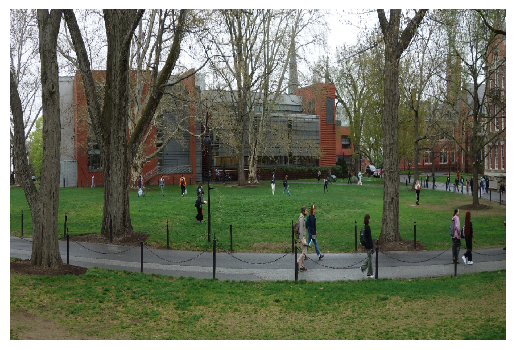

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


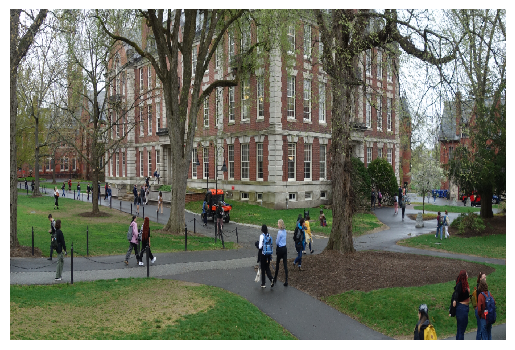

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


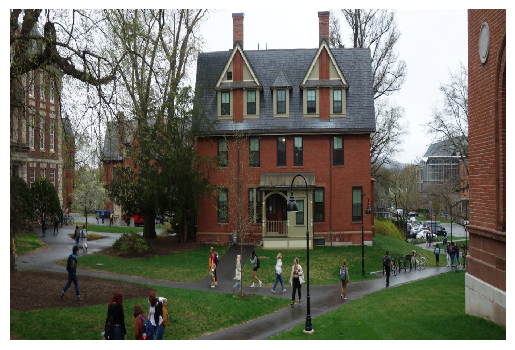

In [2]:
n_rows,n_cols,nc_clr = lawn1.shape
ar = n_rows/n_cols
print(ar)
pxg,pyg = np.meshgrid(np.linspace(-1,1,n_cols),np.linspace(-ar,ar,n_rows), indexing='xy')
print(pxg.min(),pxg.max(),pyg.min(),pyg.max())
f = 1.5 # 10.7  # focal length of the camera I used
s = f*1.2
print(f*np.arctan(-1/f),f*np.arctan(1/f))
print(f*-ar/np.sqrt(1+f*f),f*ar/np.sqrt(1+f*f))
print(f*ar/np.sqrt(f*f))

pthg = f*np.tan(pxg/s)
phg = pyg/s/np.cos(pxg/s)

print(phg.min(),phg.max(),pthg.min(),pthg.max())
plt.plot(pthg[::64,::64],phg[::64,::64],'c+')
plt.show()

#pthg = f*np.arctan(pxg/f)
#phg = f*pyg/(np.sqrt(pxg*pxg+f*f))

print(pthg.min(),pthg.max(),phg.min(),phg.max())
interp1 = RegularGridInterpolator((pyg[:,0].ravel(),pxg[0,:].ravel()), lawn1, bounds_error=False, fill_value=0.0)
cyl1 =  interp1((phg,pthg))
imshow(cyl1)
interp2 = RegularGridInterpolator((pyg[:,0].ravel(),pxg[0,:].ravel()), lawn2, bounds_error=False, fill_value=0.0)
cyl2 =  interp2((phg,pthg))
imshow(cyl2)
interp3 = RegularGridInterpolator((pyg[:,0].ravel(),pxg[0,:].ravel()), lawn3, bounds_error=False, fill_value=0.0)
cyl3 =  interp3((phg,pthg))
imshow(cyl3)
interp4 = RegularGridInterpolator((pyg[:,0].ravel(),pxg[0,:].ravel()), lawn4, bounds_error=False, fill_value=0.0)
cyl4 =  interp4((phg,pthg))
imshow(cyl4)
interp5 = RegularGridInterpolator((pyg[:,0].ravel(),pxg[0,:].ravel()), lawn5, bounds_error=False, fill_value=0.0)
cyl5 =  interp5((phg,pthg))
imshow(cyl5)
# TODO:  Convert all images to cylindrical projections.  Since they are all the same size and taken with the same camera, the same transformation should work.

The next step is to identify SIFT points in each image.  You can review the previous lab for how to do this.

In [3]:
# TODO:  Identify SIFT keypoints in each image
sift = cv.xfeatures2d.SIFT_create()
k1, d1 = sift.detectAndCompute((cyl1*255).astype(np.uint8), None)
k2, d2 = sift.detectAndCompute((cyl2*255).astype(np.uint8), None)
k3, d3 = sift.detectAndCompute((cyl3*255).astype(np.uint8), None)
k4, d4 = sift.detectAndCompute((cyl4*255).astype(np.uint8), None)
k5, d5 = sift.detectAndCompute((cyl5*255).astype(np.uint8), None)
print(len(d1),len(d2),len(d3),len(d4),len(d5))

10763 11681 12960 15262 10802


In [4]:
print(len(d1),len(d2),len(d3),len(d4),len(d5))

10763 11681 12960 15262 10802


In [5]:
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
match23 = bf.match(d2,d3)

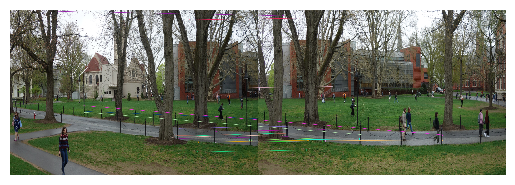

In [6]:
sm23 = sorted(match23, key = lambda x:x.distance)
# draw first 20 matches
mi23 = cv.drawMatches((cyl2*255).astype(np.uint8), k2, (cyl3*255).astype(np.uint8), k3, sm23[:20], (cyl3*255).astype(np.uint8), flags=2)
imshow(mi23)

Finally, we need to identify the offset between each pair of images.  This may be more difficult for ones with only a bit of overlap.  I therefore suggest starting with #2 and #3.  Before trying to determine the offset in code, let's see if we can do it visually.  Plot the x offset between matched pairs of keypoints.  Can you see a line?  Do the same for the y offset.

11681
11680
12955


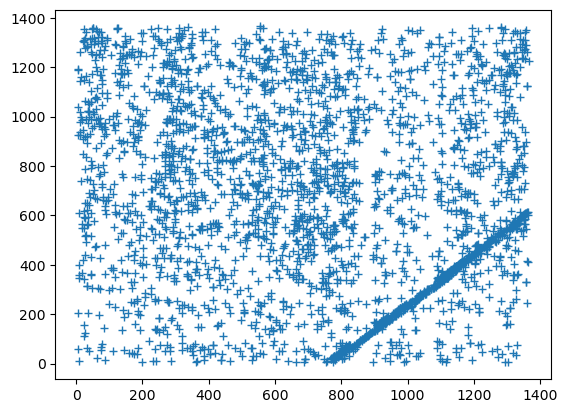

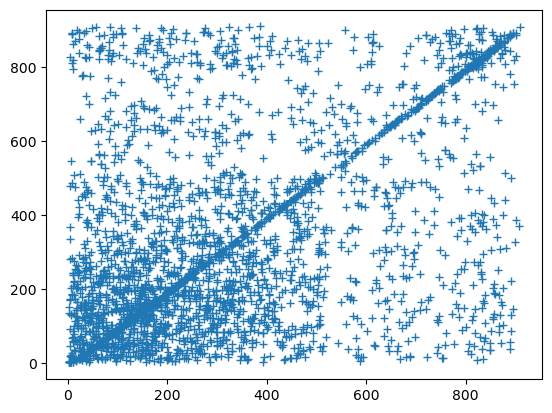

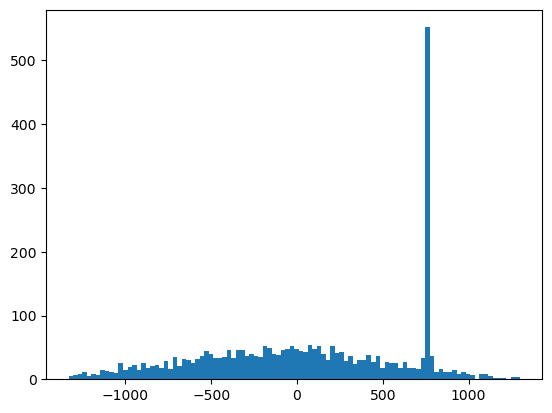

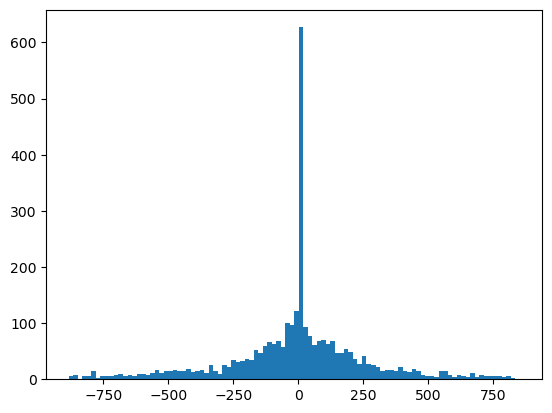

In [7]:
# TODO: plot the x offsets between pairs of matched keypoints.  Also plot the y offset.
print(len(k2))
print(np.array([match23[i].queryIdx for i in range(len(match23))]).max())
print(np.array([match23[i].trainIdx for i in range(len(match23))]).max())
m23_p1 = np.array([k2[match23[i].queryIdx].pt for i in range(len(match23))])
m23_p2 = np.array([k3[match23[i].trainIdx].pt for i in range(len(match23))])
plt.plot(m23_p1[:,0],m23_p2[:,0],'+')
plt.show()
plt.plot(m23_p1[:,1],m23_p2[:,1],'+')
plt.show()
plt.hist(m23_p1[:,0]-m23_p2[:,0],100)
plt.show()
plt.hist(m23_p1[:,1]-m23_p2[:,1],100)
plt.show()

752
9
(912, 1368, 3) (912, 1368, 3)


C:\Users\nhowe\AppData\Local\Temp\ipykernel_36752\2850314786.py:14: RuntimeWarning: invalid value encountered in divide
  imshow(pan23/w23)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


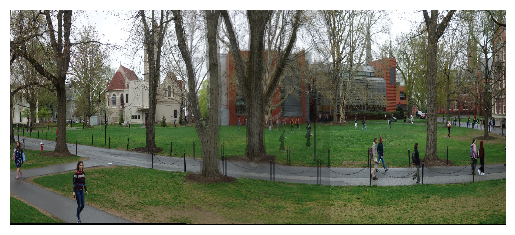

In [8]:
import scipy.stats as stats
xoff = round(stats.mode(np.round(m23_p1[:,0]-m23_p2[:,0]),keepdims=False)[0])
print(xoff)
yoff = round(stats.mode(np.round(m23_p1[:,1]-m23_p2[:,1]),keepdims=False)[0])
print(yoff)
print(cyl2.shape,cyl3.shape)
pan23 = np.zeros((int(912+yoff),int(1368+xoff),3))
w23 = np.zeros((int(912+yoff),int(1368+xoff),1))
pan23[:912,:1368,:] = cyl2
w23[:912,:1368] = 1
pan23[4:912+4,xoff:1368+xoff,:] = pan23[4:912+4,xoff:1368+xoff,:]+cyl3
w23[4:912+4,xoff:1368+xoff] = w23[4:912+4,xoff:1368+xoff]+1
#imshow(w23)
imshow(pan23/w23)

### Sources

https://courses.cs.washington.edu/courses/cse576/05sp/papers/MSR-TR-2004-92.pdf